# Develop an axis-aligned object detection pipeline to detect solar panels from satellite imagery

## Data Exploration and Understanding [3 marks]

for visualizing leafmap, please visit - https://colab.research.google.com/drive/1ivGKNM5jALpPd2N2s61C2eptW32XhZXw?usp=sharing  

In [ ]:
!pip install pyproj leafmap osmnx

In [ ]:
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import re
from pyproj import Proj, transform
import leafmap
from ipyleaflet import Popup
import csv
from PIL import Image
from sklearn.cluster import DBSCAN
import pandas as pd

### 1. Dataset statistics [0.5 marks]


####a) How many instances of solar panels are present in the dataset?

In [ ]:
label_dir = '/content/drive/MyDrive/AI4SG/Assignment_1/Labels/labels_native'

labels_per_image = []

for filename in os.listdir(label_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(label_dir, filename)
        with open(file_path, 'r') as file:
            label_count = len(file.readlines())
            labels_per_image.append(label_count)

# Convert the list of label counts to a Counter to get value counts
label_counts = Counter(labels_per_image)

# Total number of solar panel instances
total_panels = sum(count * num_images for num_images, count in label_counts.items())

# Display the total number of solar panel instances
print(f"Total number of solar panel instances: {total_panels}")

Total number of solar panel instances: 29625


#### b) Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.

In [ ]:
# Display the value counts for labels per image
print("Value counts for labels per image (number of images with X labels):")
for label_count, num_images in sorted(label_counts.items()):
    print(f"{num_images} images have {label_count} labels")

Value counts for labels per image (number of images with X labels):
81 images have 1 labels
167 images have 2 labels
221 images have 3 labels
218 images have 4 labels
217 images have 5 labels
189 images have 6 labels
170 images have 7 labels
184 images have 8 labels
169 images have 9 labels
121 images have 10 labels
97 images have 11 labels
84 images have 12 labels
69 images have 13 labels
49 images have 14 labels
46 images have 15 labels
41 images have 16 labels
36 images have 17 labels
25 images have 18 labels
29 images have 19 labels
14 images have 20 labels
4 images have 21 labels
1 images have 22 labels
4 images have 23 labels
2 images have 24 labels
4 images have 25 labels
3 images have 26 labels
5 images have 27 labels
5 images have 28 labels
15 images have 29 labels
20 images have 30 labels
8 images have 31 labels
7 images have 32 labels
13 images have 33 labels
19 images have 34 labels
10 images have 35 labels
6 images have 36 labels
17 images have 37 labels
13 images have 38 

In [ ]:
label_dir = '/content/drive/MyDrive/AI4SG/Assignment_1/Labels/labels_native'

class_counts = Counter()  # To count the number of objects per class

for filename in os.listdir(label_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(label_dir, filename)
        with open(file_path, 'r') as file:
            lines = file.readlines()

            for line in lines:
                class_id = int(line.split()[0])  # The first value is the class ID
                class_counts[class_id] += 1

# Display the counts for each class
print("\nNumber of objects per class:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count} objects")


Number of objects per class:
Class 0: 29267 objects
Class 1: 130 objects
Class 2: 228 objects


### 2. Calculate the statistics of the area of solar panels in meters [0.5 marks]


#### a) What method was used to compute the area (in meters) for a single instance?

Each `.txt` file provides the normalized center coordinates `(x-center, y-center)` and bounding box dimensions `(x-width, y-width)` for each solar panel instance. These values are normalized by the chip size (416x416 pixels for native resolution).

To compute the area of a solar panel in meters:

**1. Denormalize the dimensions:**
Multiply the `x-width` and `y-width` by the chip size (416 for native resolution).

**2. Convert to meters:**
For native resolution images, the spatial resolution is 0.31 meters per pixel.

**3. Calculate the area:**
 Multiply the denormalized x-width and y-width (both in meters) to compute the area:
$$ Area = (x-width\ in\ meter)*(y-width\ in\ meters) $$


#### b) What is the mean area and standard deviation?

In [ ]:
# Define constants for native and HD images
native_resolution = 0.31  # meters per pixel for native resolution
native_chip_size = 416    # 416x416 for native resolution images

# Directory where the label .txt files are stored (adjust path as needed)
label_dir = '/content/drive/MyDrive/AI4SG/Assignment_1/Labels/labels_native'

# List to store the areas of solar panels
solar_panel_areas = []

# Loop over all files in the directory
for filename in os.listdir(label_dir):
    if filename.endswith(".txt"):
        # Open the file and process each line (each line is one solar panel object)
        file_path = os.path.join(label_dir, filename)
        with open(file_path, 'r') as file:
            for line in file:
                # Each line format: category, x-center, y-center, x-width, y-width
                label_data = line.split()
                category = int(label_data[0])  # not used in the area calculation
                x_center, y_center = float(label_data[1]), float(label_data[2])  # centers not used here
                x_width_norm, y_width_norm = float(label_data[3]), float(label_data[4])  # normalized widths

                x_width_meters = x_width_norm * native_chip_size * native_resolution
                y_width_meters = y_width_norm * native_chip_size * native_resolution

                # Compute the area in square meters
                area_meters = x_width_meters * y_width_meters
                solar_panel_areas.append(area_meters)

# Convert the areas list to a numpy array
solar_panel_areas = np.array(solar_panel_areas)

# Calculate mean and standard deviation of the areas
mean_area = np.mean(solar_panel_areas)
std_area = np.std(solar_panel_areas)

# Print the mean and standard deviation
print(f"Mean area of solar panels: {mean_area:.2f} square meters")
print(f"Standard deviation of the areas: {std_area:.2f} square meters")

Mean area of solar panels: 191.52 square meters
Standard deviation of the areas: 630.70 square meters


#### c) Plot the histogram of areas. What do you observe?

In [ ]:
print(solar_panel_areas)

[23.064  71.4984 72.075  ... 46.4163 24.986  14.9916]


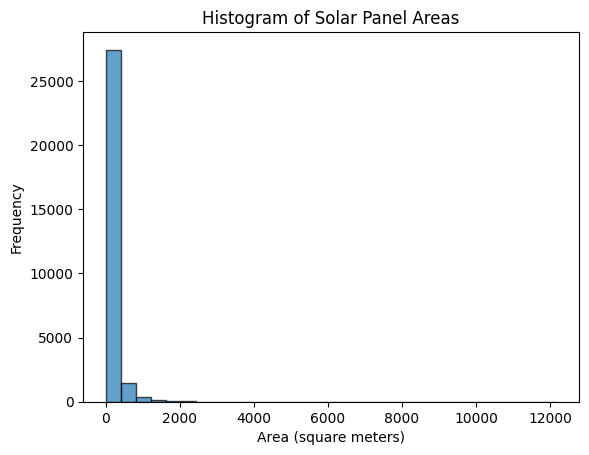

In [ ]:
# Plot a histogram of the areas
plt.hist(solar_panel_areas, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Solar Panel Areas')
plt.xlabel('Area (square meters)')
plt.ylabel('Frequency')
plt.show()

#### Observations:

> The histogram shows a right-skewed distribution, indicating that most solar panels have smaller areas, but there are some instances with significantly larger areas. This suggests that while the majority of solar panels are relatively small, there are a few outliers with much larger sizes.

### 3. Georeferencing [2 marks]
a) Find each bounding box's center coordinate (longitude, latitude) (Hint: use the information provided in the README file). Explain your method and show the verification with Google Maps Satellite view that your identification is correct. [1 mark]

b) Visualize the geolocations using the leafmap library with SATELLITE basemap. [https://leafmap.org/] Where are the clusters located? [1 mark]


### Method Overview:

- The filename provides the tile ID, minimum X and Y bounds, and window size (chip size).
- The label file contains the normalized coordinates of the center of the bounding box (x-center and y-center) and the width and height of the bounding box.
- These normalized values are scaled by the chip size (416 pixels) to get the actual pixel coordinates of the solar panel in the chip image.
- These pixel coordinates are added to the minimum X and Y bounds to get the absolute pixel coordinates in the full tile.
- Using the pixel coordinates and the geotransform matrix for the corresponding tile (provided in the README), we calculate the UTM (Universal Transverse Mercator) coordinates.
- The formula to convert pixel coordinates to UTM coordinates:
> utm_x = x_origin + pixel_x * pixel_width
-
> utm_y = y_origin + pixel_y * pixel_height
- The EPSG:32633 system (UTM Zone 33N) is used to convert them to latitude and longitude for visualization on Google Maps.

### Verification:

- After obtaining the latitude and longitude, we verify the accuracy by plotting these coordinates on Google Maps in Satellite View.

### Implementation:

In [ ]:
# Function to parse the filename and extract tile_id, min_x, min_y, window_size
def parse_filename(filename):
    pattern = re.compile(r"native_(\d+)__x0_(\d+)_y0_(\d+)_dxdy_(\d+)")
    match = pattern.search(filename)
    if match:
        tile_id = int(match.group(1))  # Tile identification number
        min_x = int(match.group(2))  # Minimum x bound
        min_y = int(match.group(3))  # Minimum y bound
        window_size = int(match.group(4))  # Window size (chip size)
        return tile_id, min_x, min_y, window_size
    return None, None, None, None

# Function to read the labels from the text files
def read_labels(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    labels = []
    for line in lines:
        parts = line.strip().split()
        category = int(parts[0])  # Category (not used for geolocation)
        x_center = float(parts[1])  # Normalized x-center
        y_center = float(parts[2])  # Normalized y-center
        x_width = float(parts[3])   # Normalized width
        y_width = float(parts[4])   # Normalized height
        labels.append((category, x_center, y_center, x_width, y_width))
    return labels

# Function to convert pixel coordinates to UTM geocoordinates using geotransform matrix
def pixel_to_geocoords(pixel_x, pixel_y, geotransform):
    x_origin, pixel_width, _, y_origin, _, pixel_height = geotransform
    utm_x = x_origin + pixel_x * pixel_width
    utm_y = y_origin + pixel_y * pixel_height
    return utm_x, utm_y

# Function to convert UTM coordinates to lat/lon
def utm_to_latlon(utm_x, utm_y):
    utm_proj = Proj(proj="utm", zone=33, ellps="WGS84")
    wgs84_proj = Proj(proj="latlong", datum="WGS84")
    lon, lat = transform(utm_proj, wgs84_proj, utm_x, utm_y)
    return lat, lon

# Geotransformation matrix for each tile (from the README file)
geotransforms = {
    1: (307670.04, 0.31, 0.0, 5434427.10, 0.0, -0.31),
    2: (312749.08, 0.31, 0.0, 5403952.86, 0.0, -0.31),
    3: (312749.08, 0.31, 0.0, 5363320.54, 0.0, -0.31),
}

In [ ]:
base_dir = "/content/drive/MyDrive/AI4SG/Assignment_1/Labels/labels_native"

latlon_geolocations = []

for filename in os.listdir(base_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(base_dir, filename)

        tile_id, min_x, min_y, window_size = parse_filename(filename)

        if tile_id is None:
            print(f"Could not parse filename: {filename}")
            continue

        labels = read_labels(file_path)

        geotransform = geotransforms[tile_id]

        chip_size = 416

        for label in labels:
            category, norm_x_center, norm_y_center, norm_x_width, norm_y_width = label

            pixel_x = norm_x_center * chip_size
            pixel_y = norm_y_center * chip_size

            absolute_pixel_x = min_x + pixel_x
            absolute_pixel_y = min_y + pixel_y

            utm_x, utm_y = pixel_to_geocoords(absolute_pixel_x, absolute_pixel_y, geotransform)

            lat, lon = utm_to_latlon(utm_x, utm_y)

            latlon_geolocations.append((lat, lon))

In [ ]:
save_path = "/content/drive/MyDrive/AI4SG/Assignment_1/geolocations.csv"

# Save the lat/lon geolocations to a CSV file
with open(save_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Latitude", "Longitude"])  # Header
    writer.writerows(latlon_geolocations)  # Write each pair of lat/lon

print(f"Geolocations saved to {save_path}")


Geolocations saved to /content/drive/MyDrive/AI4SG/Assignment_1/geolocations.csv


In [ ]:
load_path = "/content/drive/MyDrive/AI4SG/Assignment_1/geolocations.csv"

# Load the lat/lon geolocations from the CSV file
loaded_geolocations = []
with open(load_path, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        lat = float(row[0])
        lon = float(row[1])
        loaded_geolocations.append((lat, lon))

print(f"Geolocations loaded from {load_path}")


Geolocations loaded from /content/drive/MyDrive/AI4SG/Assignment_1/geolocations.csv


In [ ]:
print(loaded_geolocations[100:110])

[(48.37016533138406, 12.521204436967496), (48.37007832818559, 12.521244245065242), (48.369987461010666, 12.521298892431602), (48.36995073854182, 12.521212765166087), (48.37003513571611, 12.521181456128765), (48.369809766655905, 12.521336824893654), (48.369784324792704, 12.521256429393635), (49.00156059016414, 12.390179935072942), (49.00122673094095, 12.39181881397334), (49.00124739284958, 12.391684205353155)]


#### Visualization on google map to verify lat,lon for verification

> To verify that geolocation we plotted just any 10 samples on map and verified by checking wether solar panel exist or not at that location

> Created on map by google feature of create my map and plotted above 10 (lat,lon) in Satellite view (done this to avoid searching lat,lon pair separately on google map)

> [Link of map](https://www.google.com/maps/d/u/0/edit?mid=1OThDcOZn1Q5pusPRmy88NacaFpFZJWk&usp=sharing)

### b) Visualize the geolocations using the leafmap library with SATELLITE basemap. [https://leafmap.org/] Where are the clusters located? [1 mark]

> Here we are not able to plot all 29625 instances on map so plotted only a few (around 100) instances here.


In [ ]:
# Visualizing using Leafmap
m = leafmap.Map(center=(loaded_geolocations[1050][0], loaded_geolocations[1050][1]), zoom=16)

# Add markers for all lat/lon coordinates
for lat, lon in loaded_geolocations[1000:1100]:
    popup = Popup(location=(lat, lon), child=leafmap.widgets.HTML(value="<b>Solar Panel</b>"))
    m.add_marker(location=(lat, lon), popup=popup)

# Display with satellite basemap
m.add_basemap("SATELLITE")
m

Map(center=[48.35411363214335, 12.51250896365723], controls=(ZoomControl(options=['position', 'zoom_in_text', …

#### Where are the clusters located?

> Here as we are unable to plot all stations on map, we try to use geocoordinates, which we collected to get insights about cluster location

In [ ]:
csv_file = '/content/drive/MyDrive/AI4SG/Assignment_1/geolocations.csv'  # Replace with your file path
df = pd.read_csv(csv_file)

# Assuming your CSV columns are named 'Latitude' and 'Longitude'
latlon = df[['Latitude', 'Longitude']].values

# Define DBSCAN parameters
eps = 0.0001  # Adjust this value based on your data scale (e.g., 0.001 ~ 100 meters, adjust if needed)
min_samples = 100  # Adjust based on your data density

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine')  # 'haversine' for geographical distance
dbscan.fit(np.radians(latlon))  # Convert lat/lon to radians for haversine distance

# Get cluster labels
labels = dbscan.labels_

# Extract unique clusters (ignoring noise points, labeled as -1)
unique_clusters = np.unique(labels[labels != -1])

# Calculate the mean latitude and longitude for each cluster
cluster_centers = []
for cluster in unique_clusters:
    cluster_points = latlon[labels == cluster]
    mean_lat = np.mean(cluster_points[:, 0])
    mean_lon = np.mean(cluster_points[:, 1])
    cluster_centers.append((mean_lat, mean_lon))

# Display the cluster coordinates
for idx, (lat, lon) in enumerate(cluster_centers):
    print(f"Cluster {idx + 1}: Center at (Latitude,Longitude): ({lat},{lon})")


Cluster 1: Center at (Latitude,Longitude): (49.004163737799864,12.393612832879736)
Cluster 2: Center at (Latitude,Longitude): (48.365502909073264,12.511142077632373)
Cluster 3: Center at (Latitude,Longitude): (48.75160642561983,12.489822337653628)
Cluster 4: Center at (Latitude,Longitude): (48.721798412917096,12.520243195490162)
Cluster 5: Center at (Latitude,Longitude): (48.729834429095504,12.457229687516957)
Cluster 6: Center at (Latitude,Longitude): (48.38680822431636,12.492927488296479)
Cluster 7: Center at (Latitude,Longitude): (48.739893874313466,12.49888590323318)
Cluster 8: Center at (Latitude,Longitude): (48.74535200875959,12.468918989821848)
Cluster 9: Center at (Latitude,Longitude): (48.7200470619953,12.45481686501408)


> In above cluster max diff between 2 points of same cluster is 10 meters.
> When we consider that 100 meters then got only 3 clusters

In [ ]:
csv_file = '/content/drive/MyDrive/AI4SG/Assignment_1/geolocations.csv'  # Replace with your file path
df = pd.read_csv(csv_file)

# Assuming your CSV columns are named 'Latitude' and 'Longitude'
latlon = df[['Latitude', 'Longitude']].values

# Define DBSCAN parameters
eps = 0.001  # Adjust this value based on your data scale (e.g., 0.001 ~ 100 meters, adjust if needed)
min_samples = 100  # Adjust based on your data density

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine')  # 'haversine' for geographical distance
dbscan.fit(np.radians(latlon))  # Convert lat/lon to radians for haversine distance

# Get cluster labels
labels = dbscan.labels_

# Extract unique clusters (ignoring noise points, labeled as -1)
unique_clusters = np.unique(labels[labels != -1])

# Calculate the mean latitude and longitude for each cluster
cluster_centers = []
for cluster in unique_clusters:
    cluster_points = latlon[labels == cluster]
    mean_lat = np.mean(cluster_points[:, 0])
    mean_lon = np.mean(cluster_points[:, 1])
    cluster_centers.append((mean_lat, mean_lon))

# Display the cluster coordinates
for idx, (lat, lon) in enumerate(cluster_centers):
    print(f"Cluster {idx + 1}: Center at (Latitude,Longitude): ({lat},{lon})")


Cluster 1: Center at (Latitude,Longitude): (49.00427758807702,12.393685008915398)
Cluster 2: Center at (Latitude,Longitude): (48.36662864818445,12.510727639349849)
Cluster 3: Center at (Latitude,Longitude): (48.7353160570748,12.464625724770151)


In [ ]:
# Load your geolocations CSV
csv_file = '/content/drive/MyDrive/AI4SG/Assignment_1/geolocations.csv'  # Replace with your file path
df = pd.read_csv(csv_file)

# Assuming your CSV columns are named 'Latitude' and 'Longitude', rename if necessary
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces

# Check the first few rows to confirm correct data
print(df.head())

# Calculate the boundary of the dataset
min_lat = df['Latitude'].min()
max_lat = df['Latitude'].max()
min_lon = df['Longitude'].min()
max_lon = df['Longitude'].max()

# Display the boundary
print(f"Bounding Box:")
print(f"Min Latitude: {min_lat}")
print(f"Max Latitude: {max_lat}")
print(f"Min Longitude: {min_lon}")
print(f"Max Longitude: {max_lon}")

# Optionally, return the bounding box as a tuple or list
bounding_box = [min_lat, min_lon, max_lat, max_lon]
print(f"Bounding Box Coordinates: {bounding_box}")


    Latitude  Longitude
0  48.995957  12.393434
1  48.995366  12.394941
2  48.995387  12.394824
3  48.995194  12.394533
4  48.995505  12.394426
Bounding Box:
Min Latitude: 48.34994641792501
Max Latitude: 49.03341300959618
Min Longitude: 12.369759918687825
Max Longitude: 12.532515558503013
Bounding Box Coordinates: [48.34994641792501, 12.369759918687825, 49.03341300959618, 12.532515558503013]


##### Observation

- Dataset covers a small region with latitudes from 48.35 to 49.03 and longitudes from 12.37 to 12.53.
- Cluster 1 is near 49.0042, 12.3936 (northern area).
- Cluster 2 is near 48.3655, 12.5111 (southern area).
- The rest of the clusters are spread within the central region of the bounding box.

> The clusters are mostly evenly distributed, representing different solar panel concentrations within the area.

## Implementing the Fundamental Functions [3 marks]


### 1) Write a function to compute IoU (Intersection over Union) https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/ between two axis-aligned bounding boxes specified in the Ultralytics YOLO format. You MUST use the shapely library [https://pypi.org/project/shapely/] and its functionalities to write your function. Show that your function provides the same or similar answer as IoU computed using `supervision` library [1 mark]


In [ ]:
!pip -q install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.6 MB/s eta 0:00:00


This code defines functions to convert YOLO format bounding boxes to the format (xmin, ymin, xmax, ymax) and to compute the Intersection over Union (IoU) using the Shapely library. It then demonstrates these functions with given bounding boxes and compares the IoU calculations with those obtained using the Supervision library.

In [ ]:
import numpy as np
from shapely.geometry import box
import supervision as sv

# Function to convert YOLO format (x_center, y_center, width, height) to (xmin, ymin, xmax, ymax)
def yolo_to_bbox(yolo_box, image_width, image_height):
    x_center, y_center, width, height = yolo_box
    xmin = (x_center - width / 2) * image_width
    xmax = (x_center + width / 2) * image_width
    ymin = (y_center - height / 2) * image_height
    ymax = (y_center + height / 2) * image_height
    return (xmin, ymin, xmax, ymax)

# Function to compute IoU using Shapely
def compute_iou_shapely(yolo_box_1, yolo_box_2, image_width, image_height):
    # Convert both boxes
    box_1 = yolo_to_bbox(yolo_box_1, image_width, image_height)
    box_2 = yolo_to_bbox(yolo_box_2, image_width, image_height)

    # Create Shapely box objects
    shapely_box_1 = box(*box_1)
    shapely_box_2 = box(*box_2)

    # Compute intersection and union areas
    intersection = shapely_box_1.intersection(shapely_box_2).area
    union = shapely_box_1.union(shapely_box_2).area

    # IoU is intersection over union
    iou = intersection / union if union != 0 else 0
    return iou

# Given bounding boxes in YOLO format (x_center, y_center, width, height)
yolo_box_1 = (50 / 400, 50 / 400, 100 / 400, 100 / 400)  # Normalized YOLO box
yolo_box_2 = (100 / 400, 100 / 400, 100 / 400, 100 / 400)  # Normalized YOLO box

image_width = 400  # Image width
image_height = 400  # Image height

# Compute IoU using Shapely
iou_shapely = compute_iou_shapely(yolo_box_1, yolo_box_2, image_width, image_height)
print("IoU (Shapely):", iou_shapely)

# Convert the bounding boxes to [xmin, ymin, xmax, ymax] format
box_1 = yolo_to_bbox(yolo_box_1, image_width, image_height)
box_2 = yolo_to_bbox(yolo_box_2, image_width, image_height)

# Convert to batch format for supervision
boxes_1_batch = np.array([box_1])
boxes_2_batch = np.array([box_2])

# Compute IoU using the `box_iou_batch` function from `supervision`
iou_supervision = sv.detection.utils.box_iou_batch(boxes_1_batch, boxes_2_batch)
print("IoU (Supervision):", iou_supervision[0][0])

if iou_shapely == iou_supervision[0][0]:
    print("Both methods give the same IoU.")
else:
    print("Methods give different IoUs.")

IoU (Shapely): 0.14285714285714285
IoU (Supervision): 0.14285714285714285
Both methods give the same IoU.


> From above result we can say that our function provides the same or similar answer as IoU computed using `supervision` library

### 2) Write a function to compute Average Precision (AP) [2 mark]

a) Use Pascal VOC 11 point interpolation method to implement the function [0.5 marks]

b) Use COCO 101-point interpolation method to implement the function [0.5 marks]

c) Use Area under Precision-Recall Curve (AP) method to implement the function [0.5 marks]

d) Randomly generate 10 images of size 100x100. Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted boxes of size 20x20 in each image. Assume there is only one class of objects. Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods [0.5 marks]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# (a)
def compute_ap_voc(precision, recall):
    """Compute Average Precision using Pascal VOC 11-point interpolation."""
    # 11-point interpolation
    ap = 0.0
    for t in np.arange(0, 1.1, 0.1):
        if np.any(recall >= t):
            p = np.max(precision[recall >= t])
        else:
            p = 0.0
        ap += p / 11.0
    return ap

# (b)
def compute_ap_coco(precision, recall):
    """Compute Average Precision using COCO 101-point interpolation."""
    # 101-point interpolation
    ap = 0.0
    for t in np.linspace(0, 1, 101):
        if np.any(recall >= t):
            p = np.max(precision[recall >= t])
        else:
            p = 0.0
        ap += p / 101.0
    return ap

# (c)
def compute_ap_area_under_curve(precision, recall):
    """Compute Average Precision using Area under Precision-Recall Curve."""
    return np.trapz(precision, recall)

# (d)
def generate_random_boxes(num_images=10, img_size=(100, 100), box_size=(20, 20)):
    """Generate random ground truth and predicted boxes."""
    gt_boxes = []
    pred_boxes = []

    for _ in range(num_images):
        gt_boxes.append(np.random.randint(0, img_size[0] - box_size[0], size=(10, 2)))
        pred_boxes.append(np.random.randint(0, img_size[0] - box_size[0], size=(10, 2)))

    return gt_boxes, pred_boxes

def compute_iou(box1, box2):
    """Compute Intersection over Union (IoU) for two boxes."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + 20, box2[0] + 20)
    y2 = min(box1[1] + 20, box2[1] + 20)

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area_box1 = 20 * 20
    area_box2 = 20 * 20
    union = area_box1 + area_box2 - intersection

    return intersection / union if union > 0 else 0

def compute_ap50(gt_boxes, pred_boxes):
    """Compute Average Precision at IoU 0.5."""
    all_precisions = []
    all_recalls = []

    for gt, pred in zip(gt_boxes, pred_boxes):
        ious = np.array([[compute_iou(g, p) for p in pred] for g in gt])
        tp = (ious >= 0.5).sum(axis=1)
        fp = (ious < 0.5).sum(axis=1)

        # Calculate precision and recall
        precision = tp / (tp + fp + 1e-6)
        recall = tp / len(gt)

        all_precisions.append(precision)
        all_recalls.append(recall)

    # Flatten the lists
    all_precisions = np.concatenate(all_precisions)
    all_recalls = np.concatenate(all_recalls)

    return all_precisions, all_recalls

# Generate random boxes
gt_boxes, pred_boxes = generate_random_boxes()

# Compute AP50
precisions, recalls = compute_ap50(gt_boxes, pred_boxes)

# Compute Average Precision using different methods
ap_voc = compute_ap_voc(precisions, recalls)
ap_coco = compute_ap_coco(precisions, recalls)
ap_auc = compute_ap_area_under_curve(precisions, recalls)

# Print the results
print(f"AP (Pascal VOC 11-point): {ap_voc:.4f}")
print(f"AP (COCO 101-point): {ap_coco:.4f}")
print(f"AP (Area under PR Curve): {ap_auc:.4f}")

AP (Pascal VOC 11-point): 0.0545
AP (COCO 101-point): 0.0416
AP (Area under PR Curve): 0.0000


> We got low AP values.
> This is expected because the predicted boxes and ground truth boxes are generated randomly, without any correlation, so their IoU (Intersection over Union) tends to be low.

#**1. Use any model from Ultralytics to train the object detection model. Show that validation loss is converged**

In [ ]:
! pip install ultralytics -q

In [ ]:
# prompt: mount my google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##ultralytics model used for object detection - **yolo v8**

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")


#training the model

In [ ]:
results = model.train(data="/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/solar_dataset.yaml",single_cls = True, epochs=100, batch = 128, imgsz=416, project="/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results")

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/solar_dataset.yaml, epochs=100, time=None, patience=100, batch=128, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results, name=train1522, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning /content/drive/.shortcut-targets-by-id/1ct-nDQUh2niIW2ts3lzYK7xLuCVmTGZi/AISG Assignment/dataset_task_3/dataset/train/labels.cache... 1830 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1830/1830 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/.shortcut-targets-by-id/1ct-nDQUh2niIW2ts3lzYK7xLuCVmTGZi/AISG Assignment/dataset_task_3/dataset/val/labels.cache... 203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 203/203 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results/train1522/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results/train1522
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.38G     0.8651     0.5265     0.8982        779        416: 100%|██████████| 15/15 [00:26<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]

                   all        203       2363      0.931      0.903      0.956      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.49G     0.8563     0.5163     0.8929        643        416: 100%|██████████| 15/15 [00:19<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

                   all        203       2363      0.931      0.903      0.958      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.59G     0.8626     0.5208     0.8969        695        416: 100%|██████████| 15/15 [00:18<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]

                   all        203       2363      0.937      0.893      0.954      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.85G     0.8877     0.5328     0.8986        551        416: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

                   all        203       2363       0.94      0.895      0.955      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100        10G     0.8977     0.5352     0.9005        499        416: 100%|██████████| 15/15 [00:18<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

                   all        203       2363      0.921      0.885      0.947      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.21G     0.9232     0.5545     0.9081        581        416: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

                   all        203       2363      0.867      0.839      0.885      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.78G     0.9458     0.5705     0.9128        641        416: 100%|██████████| 15/15 [00:17<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]

                   all        203       2363        0.9      0.843       0.91       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       8.8G      0.974     0.5832     0.9248        869        416: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

                   all        203       2363      0.914       0.83      0.908      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.11G      0.959      0.585     0.9173        537        416: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

                   all        203       2363      0.906      0.816      0.905      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.61G     0.9632     0.5823     0.9199        590        416: 100%|██████████| 15/15 [00:18<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

                   all        203       2363      0.897      0.809      0.893      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.54G     0.9795     0.5924     0.9324        451        416: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]

                   all        203       2363      0.852      0.812      0.878      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       8.5G     0.9876     0.5889     0.9263        662        416: 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all        203       2363      0.907      0.833      0.909      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.68G      1.001     0.5954      0.931        698        416: 100%|██████████| 15/15 [00:22<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

                   all        203       2363      0.905      0.854       0.92      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      10.5G     0.9629     0.5785     0.9242        691        416: 100%|██████████| 15/15 [00:17<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]

                   all        203       2363      0.924      0.862      0.935        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.87G     0.9518     0.5742     0.9183        777        416: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

                   all        203       2363      0.924      0.863      0.935      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.51G     0.9452     0.5624     0.9135        804        416: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

                   all        203       2363      0.908      0.871      0.929      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.33G     0.9579     0.5657     0.9192        727        416: 100%|██████████| 15/15 [00:17<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

                   all        203       2363      0.924      0.848      0.931      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.56G     0.8961      0.536     0.9057        745        416: 100%|██████████| 15/15 [00:18<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

                   all        203       2363      0.924      0.855      0.929      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.25G     0.9011     0.5444     0.9094        550        416: 100%|██████████| 15/15 [00:18<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

                   all        203       2363      0.896      0.837      0.906      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      10.2G     0.9273     0.5547      0.914        562        416: 100%|██████████| 15/15 [00:18<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

                   all        203       2363      0.926      0.876      0.941      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.18G     0.9118     0.5458     0.9073        600        416: 100%|██████████| 15/15 [00:17<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]

                   all        203       2363      0.925      0.876      0.941      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      8.58G      0.912     0.5364     0.9068        593        416: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

                   all        203       2363      0.934      0.874      0.939      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.06G     0.9272     0.5402     0.9133        871        416: 100%|██████████| 15/15 [00:18<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

                   all        203       2363      0.932      0.887      0.945      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      8.77G     0.8852     0.5325     0.9036        508        416: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

                   all        203       2363      0.934      0.868      0.944      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.95G     0.9155      0.542     0.9078        564        416: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

                   all        203       2363      0.934      0.884      0.942      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      10.1G      0.895     0.5343     0.9073        505        416: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]

                   all        203       2363       0.94      0.874      0.944      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.92G     0.9127     0.5426      0.908        637        416: 100%|██████████| 15/15 [00:18<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

                   all        203       2363      0.934      0.895      0.949       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.87G     0.8765     0.5269     0.9005        612        416: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

                   all        203       2363      0.942      0.867       0.94      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.79G     0.8891     0.5318     0.9068        787        416: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]

                   all        203       2363      0.927      0.883      0.937      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.92G     0.8659     0.5201     0.8963        553        416: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

                   all        203       2363      0.944      0.898      0.957      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.24G     0.8632     0.5178     0.8977        545        416: 100%|██████████| 15/15 [00:18<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all        203       2363      0.931       0.91      0.956      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.44G     0.8884     0.5296     0.9046        638        416: 100%|██████████| 15/15 [00:17<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

                   all        203       2363      0.946      0.879       0.95      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       7.8G     0.8732     0.5199     0.9018        606        416: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

                   all        203       2363      0.928      0.899      0.946      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.99G     0.8576     0.5142     0.8959        768        416: 100%|██████████| 15/15 [00:19<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]

                   all        203       2363      0.946      0.893       0.95      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.12G     0.8773     0.5196     0.9016        505        416: 100%|██████████| 15/15 [00:18<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]

                   all        203       2363      0.941      0.896       0.95      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.71G      0.855      0.507     0.8933        557        416: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]

                   all        203       2363      0.951      0.899      0.958      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.09G     0.8698     0.5133     0.8993        635        416: 100%|██████████| 15/15 [00:18<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

                   all        203       2363      0.941      0.906      0.956      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.35G     0.8608      0.512     0.8977        778        416: 100%|██████████| 15/15 [00:18<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

                   all        203       2363      0.935      0.893      0.951      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.04G     0.8428     0.5074     0.8904        791        416: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all        203       2363      0.916      0.903      0.947      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.47G      0.831     0.4987       0.89        572        416: 100%|██████████| 15/15 [00:18<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]

                   all        203       2363      0.948      0.887      0.953      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.46G     0.8471     0.5077     0.8973        951        416: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

                   all        203       2363      0.943      0.902      0.956      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.12G     0.8335     0.5043     0.8887        560        416: 100%|██████████| 15/15 [00:19<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

                   all        203       2363       0.96      0.895      0.964      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.71G      0.838     0.5039     0.8915        799        416: 100%|██████████| 15/15 [00:19<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

                   all        203       2363      0.939      0.908      0.961      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      10.1G     0.8353     0.5036     0.8913        552        416: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

                   all        203       2363      0.949      0.898      0.957      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.24G      0.829     0.4948     0.8856        570        416: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

                   all        203       2363      0.955       0.89       0.96      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.71G     0.8314     0.5015     0.8938        475        416: 100%|██████████| 15/15 [00:17<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]

                   all        203       2363      0.908      0.755      0.855      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.39G     0.8178     0.4899     0.8873        598        416: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

                   all        203       2363      0.949      0.914      0.962      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.02G     0.8416        0.5     0.8906        580        416: 100%|██████████| 15/15 [00:19<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]

                   all        203       2363      0.948      0.917      0.961      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.93G     0.8124     0.4844     0.8842        588        416: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.30s/it]

                   all        203       2363      0.948      0.914      0.962      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.82G     0.8004     0.4802     0.8831        754        416: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

                   all        203       2363      0.953      0.914      0.963      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.32G     0.8011     0.4782     0.8827        718        416: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

                   all        203       2363      0.951      0.912      0.964      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.22G     0.8015     0.4774     0.8814        631        416: 100%|██████████| 15/15 [00:18<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

                   all        203       2363      0.953      0.916      0.968      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.25G     0.7977     0.4779     0.8861        693        416: 100%|██████████| 15/15 [00:18<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

                   all        203       2363      0.949      0.923      0.967      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.73G     0.8058     0.4815     0.8841        522        416: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

                   all        203       2363      0.953      0.912      0.967      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.36G     0.8101     0.4833     0.8808        681        416: 100%|██████████| 15/15 [00:18<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]

                   all        203       2363      0.957      0.919      0.968      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.99G     0.7889      0.474     0.8781        738        416: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

                   all        203       2363      0.938      0.926      0.965      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.14G     0.8022      0.479     0.8792        528        416: 100%|██████████| 15/15 [00:18<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

                   all        203       2363      0.958      0.919      0.968      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.57G     0.7788     0.4722     0.8798        647        416: 100%|██████████| 15/15 [00:19<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]

                   all        203       2363      0.962      0.919      0.966      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.63G     0.8012     0.4768     0.8801        622        416: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]

                   all        203       2363      0.957      0.923      0.968      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.06G     0.7872     0.4717       0.88        573        416: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

                   all        203       2363      0.964      0.931      0.972      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.22G     0.8039     0.4752     0.8794        668        416: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

                   all        203       2363      0.966      0.923      0.973        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.17G     0.7663     0.4633     0.8799        655        416: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

                   all        203       2363       0.96      0.935      0.972      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.62G     0.7706     0.4666     0.8724        597        416: 100%|██████████| 15/15 [00:19<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

                   all        203       2363      0.956      0.933      0.969      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.07G      0.769     0.4666      0.875        645        416: 100%|██████████| 15/15 [00:18<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all        203       2363       0.96      0.924       0.97      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       8.1G     0.7645     0.4589     0.8748        558        416: 100%|██████████| 15/15 [00:18<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all        203       2363      0.961      0.915      0.969        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.33G     0.7551     0.4604     0.8727        761        416: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

                   all        203       2363       0.97      0.911      0.969       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.83G     0.7457     0.4548     0.8703        512        416: 100%|██████████| 15/15 [00:18<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]

                   all        203       2363      0.958      0.913      0.968       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.75G     0.7594     0.4588      0.871        582        416: 100%|██████████| 15/15 [00:17<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

                   all        203       2363      0.963      0.917      0.973      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      9.11G     0.7512     0.4577     0.8735        517        416: 100%|██████████| 15/15 [00:18<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.19s/it]

                   all        203       2363       0.95      0.932      0.972      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      11.2G     0.7474     0.4546     0.8715        490        416: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

                   all        203       2363       0.96      0.929      0.972      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.26G     0.7474     0.4546     0.8709        587        416: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all        203       2363      0.966      0.932      0.972      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.29G     0.7588     0.4566     0.8715        702        416: 100%|██████████| 15/15 [00:16<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]

                   all        203       2363      0.963      0.928      0.974      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.22G     0.7494     0.4532     0.8694        544        416: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]

                   all        203       2363      0.963      0.937      0.975      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.29G     0.7407     0.4505       0.87        592        416: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

                   all        203       2363      0.958      0.937      0.975      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.52G     0.7394     0.4463     0.8687        648        416: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.38s/it]

                   all        203       2363       0.97      0.939      0.978      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      8.07G     0.7145     0.4374     0.8644        757        416: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

                   all        203       2363      0.959      0.943      0.977      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.87G     0.7311     0.4446     0.8671        617        416: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

                   all        203       2363      0.967       0.94      0.978      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.12G     0.7224     0.4419     0.8649        649        416: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]

                   all        203       2363      0.966      0.933      0.974      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.65G      0.725     0.4425     0.8667        631        416: 100%|██████████| 15/15 [00:18<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

                   all        203       2363       0.96      0.938      0.975      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.21G     0.7028     0.4325     0.8671        515        416: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

                   all        203       2363      0.969      0.937      0.976       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.02G     0.7278     0.4435     0.8647        914        416: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

                   all        203       2363      0.969      0.939      0.977      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.08G     0.7204     0.4374     0.8666        745        416: 100%|██████████| 15/15 [00:18<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

                   all        203       2363      0.974      0.937      0.978      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.84G     0.7267     0.4418     0.8669       1005        416: 100%|██████████| 15/15 [00:18<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

                   all        203       2363      0.966      0.941      0.977       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.86G     0.7212     0.4387     0.8619        616        416: 100%|██████████| 15/15 [00:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

                   all        203       2363      0.967      0.939      0.977      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      9.18G      0.708     0.4317      0.863        768        416: 100%|██████████| 15/15 [00:19<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]

                   all        203       2363      0.964      0.939      0.976      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.43G     0.7081     0.4292     0.8622        595        416: 100%|██████████| 15/15 [00:18<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

                   all        203       2363      0.973      0.934      0.977      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.83G     0.6943     0.4269      0.861        546        416: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

                   all        203       2363      0.968      0.942      0.978      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.38G     0.7147     0.4387     0.8677        503        416: 100%|██████████| 15/15 [00:18<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]

                   all        203       2363      0.977      0.934      0.978      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      9.19G     0.6796     0.4196     0.8592        631        416: 100%|██████████| 15/15 [00:19<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

                   all        203       2363      0.971      0.938      0.978      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.99G     0.6934     0.4289     0.8609        657        416: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

                   all        203       2363      0.967      0.936      0.977      0.821


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.61G     0.6468     0.4061     0.8456        336        416: 100%|██████████| 15/15 [00:24<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]

                   all        203       2363      0.965      0.925      0.974      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.86G     0.6171     0.3869     0.8409        357        416: 100%|██████████| 15/15 [00:18<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]

                   all        203       2363      0.966       0.93      0.976      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      8.37G     0.6066     0.3827     0.8404        423        416: 100%|██████████| 15/15 [00:16<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

                   all        203       2363      0.971      0.939      0.978      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.94G     0.6039     0.3775      0.838        274        416: 100%|██████████| 15/15 [00:17<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all        203       2363      0.968      0.935      0.976      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.01G     0.5836     0.3698     0.8375        490        416: 100%|██████████| 15/15 [00:16<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]

                   all        203       2363      0.969      0.944      0.979       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.54G      0.584     0.3702      0.836        400        416: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

                   all        203       2363      0.969       0.94      0.978      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.61G     0.5783     0.3695       0.83        381        416: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

                   all        203       2363      0.968      0.942      0.979       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      8.58G     0.5842     0.3729     0.8343        352        416: 100%|██████████| 15/15 [00:17<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]

                   all        203       2363      0.973      0.939      0.978      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.31G     0.5796     0.3679     0.8336        285        416: 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

                   all        203       2363      0.973      0.942      0.979      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       7.1G       0.57     0.3635     0.8316        513        416: 100%|██████████| 15/15 [00:16<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.38s/it]

                   all        203       2363       0.97      0.943      0.978      0.835



100 epochs completed in 0.640 hours.
Optimizer stripped from /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results/train1522/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results/train1522/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results/train1522/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


                   all        203       2363      0.974      0.942      0.979      0.837
               Class 0        203       2363      0.974      0.942      0.979      0.837
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results/train1522


change this

In [ ]:
import torch

In [ ]:
#model_state_path = "/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results/train1522/ishu_state_dict.pth"
#torch.save(model.state_dict(), model_state_path)

In [ ]:
model_state_path = "/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results/train1522/ishu_state_dict.pth"

In [ ]:
from ultralytics import YOLO
model = YOLO("/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results/train1522/weights/best.pt")

In [ ]:
results

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f1989ba87d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:

import PIL

##**plots to conclude that the validation loss is converged**

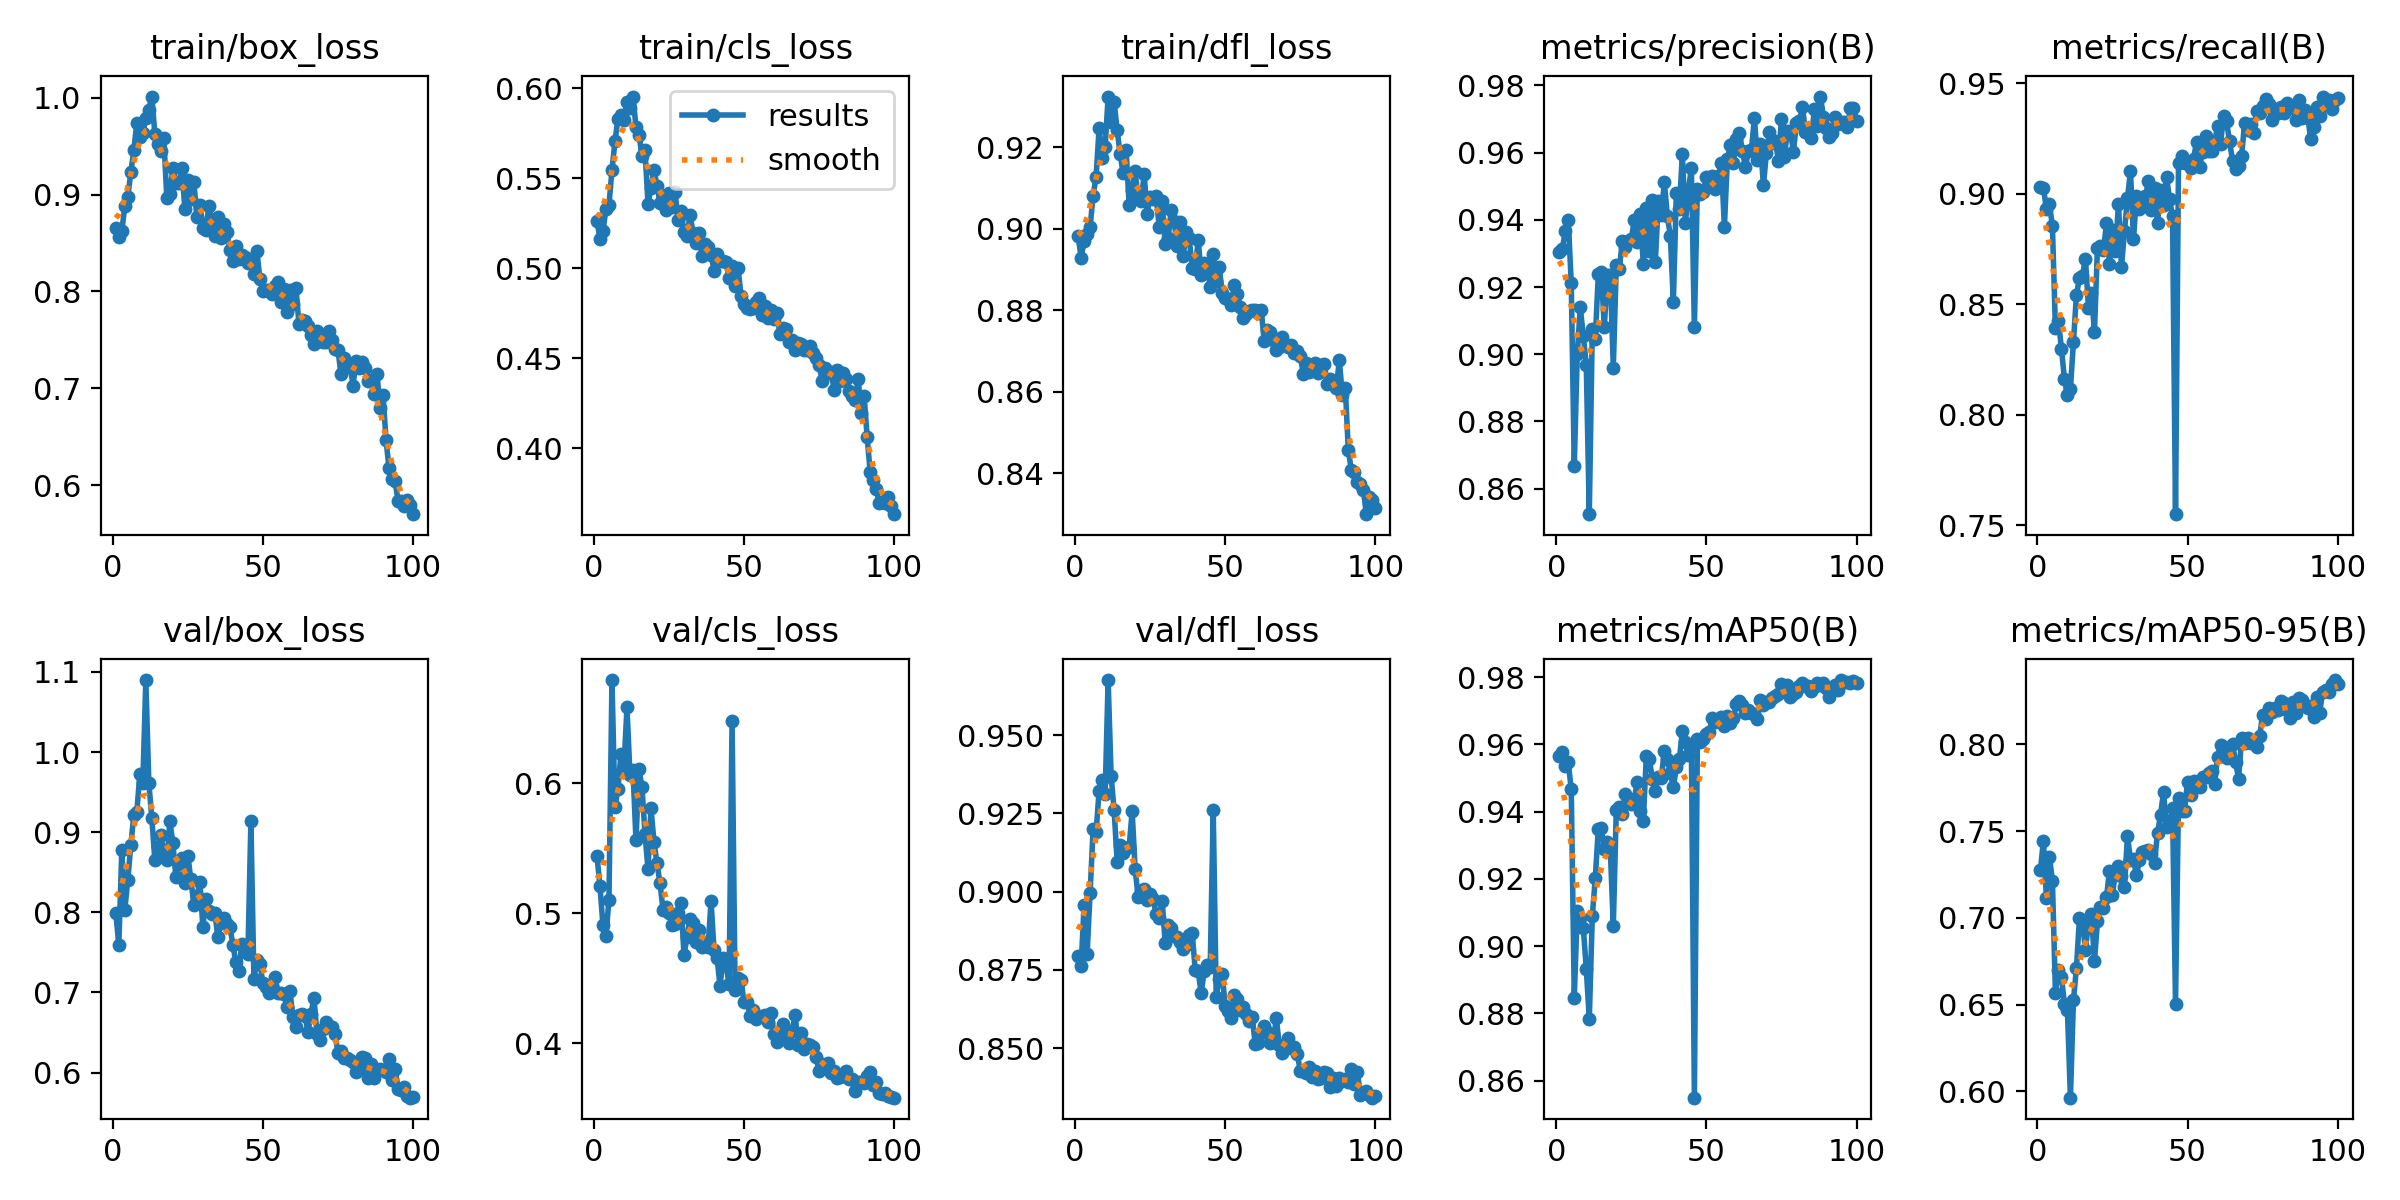

In [ ]:
# prompt: show image for a given path

from IPython.display import Image

# Assuming 'path/to/image.jpg' is the correct path to your image
# Replace with your actual image path
image_path = "/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results/train1522/results.png"

# Display the image using IPython.display
Image(filename=image_path)


#**2. Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels.**

In [ ]:
source = "/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images"

In [ ]:
# source = "/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_3__x0_9990_y0_9864_dxdy_416.jpg"

In [ ]:
results = model(source, stream=True)

In [ ]:
results

<generator object BasePredictor.stream_inference at 0x7e8e0a5e2e60>

In [ ]:
for r in results:
    print(r.boxes)


image 1/1 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_3__x0_9990_y0_9864_dxdy_416.jpg: 640x640 18 Class 0s, 10.4ms
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
conf: tensor([0.9900, 0.9615, 0.9344, 0.8878, 0.8749, 0.8614, 0.8377, 0.8072, 0.7845, 0.7521, 0.7454, 0.7069, 0.6953, 0.6209, 0.5930, 0.5799, 0.4908, 0.4661], device='cuda:0')
data: tensor([[382.8348, 164.4591, 413.7895, 205.6878,   0.9900,   0.0000],
        [258.5668, 166.4808, 390.8935, 346.4614,   0.9615,   0.0000],
        [154.1413, 296.8729, 252.1271, 414.1200,   0.9344,   0.0000],
        [315.3942, 127.5946, 367.4747, 185.5019,   0.8878,   0.0000],
        [354.6225, 102.8559, 407.3429, 160.6404,   0.8749,   0.0000],
        [219.3569, 186.2171, 331.3441, 374.2089,   0.8614,   0.0000],
        [223.1268, 264.7341, 306.8192, 388.8160,   0.8377,   0.0000]

In [ ]:
for i, r in results:
  print(i)
  # Plot results image
  im_bgr = r.plot()  # BGR-order numpy array
  im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

  # Show results to screen (in supported environments)
  r.show()

  # Save results to disk
  r.save(filename=f"results{i}.jpg")



##**making predictions and saving them in result directory**

In [ ]:
model.predict(source, save=True, imgsz=416, conf=0.5)


image 1/509 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_1__x0_1016_y0_6504_dxdy_416.jpg: 416x416 5 Class 0s, 13.9ms
image 2/509 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_1__x0_10313_y0_12985_dxdy_416.jpg: 416x416 4 Class 0s, 11.0ms
image 3/509 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_1__x0_10336_y0_10994_dxdy_416.jpg: 416x416 3 Class 0s, 13.9ms
image 4/509 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_1__x0_10683_y0_744_dxdy_416.jpg: 416x416 3 Class 0s, 7.5ms
image 5/509 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_1__x0_1073_y0_8078_dxdy_416.jpg: 416x416 9 Class 0s, 8.0ms
image 6/509 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_1__x0_1081_y0_8886_dxdy_416.jpg: 416x416 10

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Class 0', 1: 'Class 1', 2: 'Class 2'}
 obb: None
 orig_img: array([[[ 90,  95,  96],
         [ 91,  96,  97],
         [ 94,  99, 100],
         ...,
         [144, 142, 164],
         [143, 142, 162],
         [140, 139, 159]],
 
        [[ 93,  98,  99],
         [ 92,  97,  98],
         [ 94,  99, 100],
         ...,
         [131, 129, 151],
         [133, 132, 152],
         [139, 138, 158]],
 
        [[ 98, 103, 104],
         [ 95, 100, 101],
         [ 94,  99, 100],
         ...,
         [115, 113, 135],
         [122, 120, 142],
         [138, 136, 158]],
 
        ...,
 
        [[ 76,  70,  81],
         [ 76,  70,  81],
         [ 75,  69,  80],
         ...,
         [ 73,  64,  74],
         [ 85,  76,  86],
         [ 94,  85,  95]],
 
        [[ 76,  70,  81],
         [ 77,  71,  82],
         [ 78,  72,  83],
   

##**checking 3-4 random samples**

In [ ]:
import os
from PIL import Image, ImageDraw

In [ ]:
source_img = "/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/"
source_label = "/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/labels/"

In [ ]:
result_path = "/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results/train15222/"

In [ ]:
result_files = [f for f in os.listdir(result_path) if os.path.isfile(os.path.join(result_path, f))]

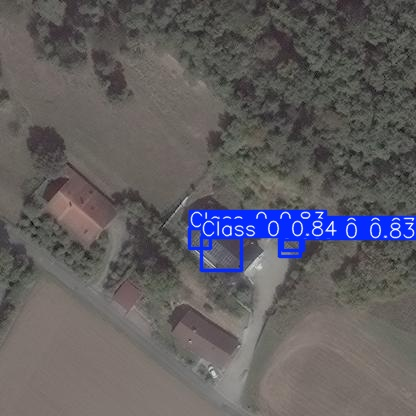

In [ ]:
from PIL import Image, ImageDraw
img = Image.open(result_path + result_files[1])
img

In [ ]:
with open(source_label + result_files[1].replace(".jpg", ".txt")) as f:
  data = [i.strip() for i in f.readlines()]

In [ ]:
data

['0 0.48557692307692313 0.5733173076923077 0.05288461538461539 0.05528846153846154',
 '0 0.5324519230769231 0.6105769230769231 0.08413461538461539 0.07692307692307693',
 '0 0.7103365384615385 0.5757211538461539 0.04567307692307693 0.040865384615384616',
 '0 0.6971153846153847 0.5961538461538461 0.04807692307692308 0.038461538461538464']

In [ ]:
draw = ImageDraw.Draw(img)

In [ ]:
#(x_center - x_width, y_center - y_width, x_center + x_width, y_center + y_width)

In [ ]:
#draw.rec\tangle((x_center - x_width, y_center - y_width, x_center + x_width, y_center + y_width), outline="yellow", width=3)

In [ ]:
!ls -l "/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/results/train15222/" | grep -v ".jpg"

total 32115


##visualizing predictions

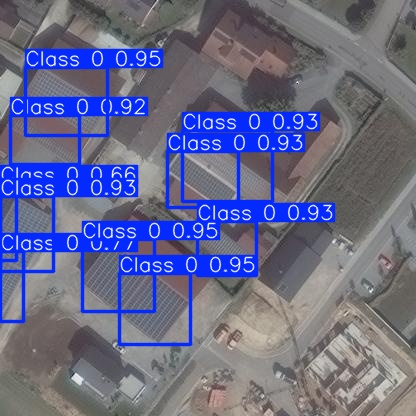

In [ ]:
img = Image.open(result_path + result_files[6])
img

0
1
2
3
4
5
6
7
8
9


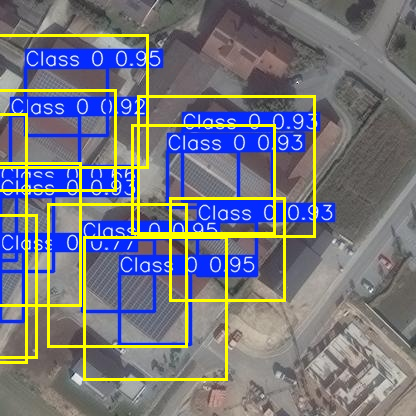

In [ ]:
from PIL import Image, ImageDraw
img = Image.open(result_path + result_files[6])
with open(source_label + result_files[6].replace(".jpg", ".txt")) as f:
  data = [i.strip() for i in f.readlines()]
draw = ImageDraw.Draw(img)
for i in range(len(data)):
  print(i)
  data_tmp = data[i].split(" ")
  x_center = int(float(data_tmp[1]) * img.size[0])
  y_center = int(float(data_tmp[2]) * img.size[1])
  x_width = int(float(data_tmp[3]) * img.size[0])
  y_width = int(float(data_tmp[4]) * img.size[1])
  draw.rectangle((x_center - x_width, y_center - y_width, x_center + x_width, y_center + y_width), outline="yellow", width=3)
img

0
1
2
3
4
5
6
7
8


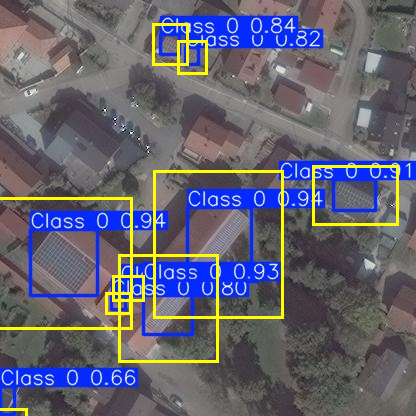

In [ ]:
from PIL import Image, ImageDraw
img = Image.open(result_path + result_files[4])
with open(source_label + result_files[4].replace(".jpg", ".txt")) as f:
  data = [i.strip() for i in f.readlines()]
draw = ImageDraw.Draw(img)
for i in range(len(data)):
  print(i)
  data_tmp = data[i].split(" ")
  x_center = int(float(data_tmp[1]) * img.size[0])
  y_center = int(float(data_tmp[2]) * img.size[1])
  x_width = int(float(data_tmp[3]) * img.size[0])
  y_width = int(float(data_tmp[4]) * img.size[1])
  draw.rectangle((x_center - x_width, y_center - y_width, x_center + x_width, y_center + y_width), outline="yellow", width=3)
img

0
1
2
3


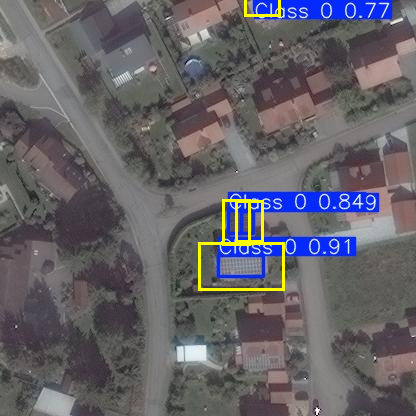

In [ ]:
from PIL import Image, ImageDraw
img = Image.open(result_path + result_files[10])
with open(source_label + result_files[10].replace(".jpg", ".txt")) as f:
  data = [i.strip() for i in f.readlines()]
draw = ImageDraw.Draw(img)
for i in range(len(data)):
  print(i)
  data_tmp = data[i].split(" ")
  x_center = int(float(data_tmp[1]) * img.size[0])
  y_center = int(float(data_tmp[2]) * img.size[1])
  x_width = int(float(data_tmp[3]) * img.size[0])
  y_width = int(float(data_tmp[4]) * img.size[1])
  draw.rectangle((x_center - x_width, y_center - y_width, x_center + x_width, y_center + y_width), outline="yellow", width=3)
img

#**3. Use supervision.metrics functionality from supervision library to compute the following**

In [ ]:
! pip install supervision -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.0 MB/s eta 0:00:00


In [ ]:
import torch
import supervision as sv
from supervision.metrics import  MeanAveragePrecision
import numpy as np

In [ ]:
def get_prediction(tmp_img_path):
  result_tmp = model.predict(tmp_img_path, save=True, imgsz=416, conf=0.5)
  return result_tmp[0].boxes.xyxy.cpu().numpy(), result_tmp[0].boxes.conf.cpu().numpy(), result_tmp[0].boxes.cls.cpu().numpy()

In [ ]:
def get_gt(img_path, img_size=416):

  label_path = img_path.replace("/images/", "/labels/")

  with open(label_path.replace(".jpg", ".txt")) as f:
    data = [i.strip() for i in f.readlines()]

  box_pos = []
  class_arr = []
  for i in range(len(data)):
    data_tmp = data[i].split(" ")
    x_center = int(float(data_tmp[1]) * img_size)
    y_center = int(float(data_tmp[2]) * img_size)
    x_width = int(float(data_tmp[3]) * img_size)
    y_width = int(float(data_tmp[4]) * img_size)

    box_pos.append(torch.tensor((x_center - x_width, y_center - y_width, x_center + x_width, y_center + y_width)))
    class_arr.append(float(data_tmp[0]))

  gt_boxes = torch.stack(box_pos, dim=0)
  gt_class = torch.tensor(class_arr)

  return gt_boxes.cpu().numpy(), gt_class.cpu().numpy()

In [ ]:
source_img = "/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/"
files = [f for f in os.listdir(source_img) if os.path.isfile(os.path.join(source_img, f))]
sample_img = files[:4]

In [ ]:
img_num = 0
sample_img

['native_1__x0_1016_y0_6504_dxdy_416.jpg',
 'native_1__x0_10313_y0_12985_dxdy_416.jpg',
 'native_1__x0_10336_y0_10994_dxdy_416.jpg',
 'native_1__x0_10683_y0_744_dxdy_416.jpg']

In [ ]:
def get_map50(img_path):
  pred_boxes, pred_confidences, pred_classes = get_prediction(img_path)
  gt_boxes, gt_classes = get_gt(img_path)

  predictions = sv.Detections(xyxy=pred_boxes, confidence=pred_confidences, class_id=pred_classes)
  targets = sv.Detections(xyxy=gt_boxes, class_id=gt_classes)

  map_metric = MeanAveragePrecision()
  map_result = map_metric.update(predictions, targets).compute()
  return map_result.map50

In [ ]:
for img_num in range(len(sample_img)):
  img_path = source_img + sample_img[img_num]
  print(f"Image: {sample_img[img_num]} ### Score: {get_map50(img_path)}")


image 1/1 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_1__x0_1016_y0_6504_dxdy_416.jpg: 416x416 5 Class 0s, 153.4ms
Speed: 1.9ms preprocess, 153.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict2
Image: native_1__x0_1016_y0_6504_dxdy_416.jpg ### Score: 0.0

image 1/1 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_1__x0_10313_y0_12985_dxdy_416.jpg: 416x416 4 Class 0s, 142.2ms
Speed: 1.8ms preprocess, 142.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict2
Image: native_1__x0_10313_y0_12985_dxdy_416.jpg ### Score: 0.0

image 1/1 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_1__x0_10336_y0_10994_dxdy_416.jpg: 416x416 3 Class 0s, 146.3ms
Speed: 1.8ms preprocess, 146.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 

In [ ]:
pred_arr = []
target_arr = []
for img_num in range(len(sample_img)):
  img_path = source_img + sample_img[img_num]

  pred_boxes, pred_confidences, pred_classes = get_prediction(img_path)
  gt_boxes, gt_classes = get_gt(img_path)

  predictions = sv.Detections(xyxy=pred_boxes, confidence=pred_confidences, class_id=pred_classes)
  targets = sv.Detections(xyxy=gt_boxes, class_id=gt_classes)
  pred_arr.append(predictions)
  target_arr.append(targets)


image 1/1 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_1__x0_1016_y0_6504_dxdy_416.jpg: 416x416 5 Class 0s, 105.1ms
Speed: 2.0ms preprocess, 105.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict2

image 1/1 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_1__x0_10313_y0_12985_dxdy_416.jpg: 416x416 4 Class 0s, 100.3ms
Speed: 1.3ms preprocess, 100.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict2

image 1/1 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/dataset/test/images/native_1__x0_10336_y0_10994_dxdy_416.jpg: 416x416 3 Class 0s, 102.1ms
Speed: 1.4ms preprocess, 102.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict2

image 1/1 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/dataset_task_3/

In [ ]:
from supervision.metrics import detection

In [ ]:
conf_matx = []
for iou_i in [0.1, 0.3, 0.5, 0.7, 0.9]:
  for conf_i in [0.1, 0.3, 0.5, 0.7, 0.9]:
    conf_matx.append(detection.ConfusionMatrix.from_detections(
                predictions=pred_arr,
                targets=target_arr,
                iou_threshold=0.5,
        classes=[0]
            ))
    print(conf_matx[-1])

ConfusionMatrix(matrix=array([[          0,          18],
       [         15,           0]]), classes=[0], conf_threshold=0.3, iou_threshold=0.5)
ConfusionMatrix(matrix=array([[          0,          18],
       [         15,           0]]), classes=[0], conf_threshold=0.3, iou_threshold=0.5)
ConfusionMatrix(matrix=array([[          0,          18],
       [         15,           0]]), classes=[0], conf_threshold=0.3, iou_threshold=0.5)
ConfusionMatrix(matrix=array([[          0,          18],
       [         15,           0]]), classes=[0], conf_threshold=0.3, iou_threshold=0.5)
ConfusionMatrix(matrix=array([[          0,          18],
       [         15,           0]]), classes=[0], conf_threshold=0.3, iou_threshold=0.5)
ConfusionMatrix(matrix=array([[          0,          18],
       [         15,           0]]), classes=[0], conf_threshold=0.3, iou_threshold=0.5)
ConfusionMatrix(matrix=array([[          0,          18],
       [         15,           0]]), classes=[0], conf_thres

In [ ]:
for i in range(len(conf_matx)):
  tmp_conf = conf_matx[i]
  precision = tmp_conf.matrix[0,0]/(tmp_conf.matrix[0,0] + tmp_conf.matrix[1,0])
  recall = tmp_conf.matrix[0,0]/(tmp_conf.matrix[0,0] + tmp_conf.matrix[0,1])
  if (precision + recall) == 0:
    f1 = 0
  else:
    f1 = 2 * (precision * recall) / (precision + recall)

  print(f"P: {precision} R: {recall} F1: {f1}")

P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0
P: 0.0 R: 0.0 F1: 0


##**bonus** **: Can you use the developed model to detect solar panels in a region of India that is not included in the original dataset?**

**Get same resolution satellite image:**

To calculate the appropriate zoom level based on the latitude of Jaipur (around 26.9° north), we use the formula for ground resolution and find the zoom level needed for 31 cm per pixel resolution:

$$
\text{Ground resolution (meters per pixel)} = \frac{156543.03 \times \cos(\text{latitude})}{2^{\text{zoom level}}}
$$

Given:

- Desired ground resolution = 31 cm/pixel = 0.31 meters/pixel
- Latitude of Jaipur ≈ 26.9° N

Step 1: Rearrange the formula to solve for the zoom level:

$$
2^{\text{zoom level}} = \frac{156543.03 \times \cos(\text{latitude})}{\text{ground resolution}}
$$

Taking the logarithm base 2 on both sides:

$$
\text{zoom level} = \log_2 \left( \frac{156543.03 \times \cos(\text{latitude})}{\text{ground resolution}} \right)
$$

Step 2: Substitute the known values:

$$
\text{zoom level} = \log_2 \left( \frac{156543.03 \times \cos(26.9^\circ)}{0.31} \right)
                  = 18.780647736774828
$$

Hence here we have taken zoom level = 19 to collect those image to keep resolution same as train data (31 cm)



In [ ]:
!pip install leafmap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.1/515.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.6/218.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.5 MB/s eta 0:00:00


In [ ]:
bounding_box = [26.8850,75.7700,26.8950,75.7800]  #Jaipur, Rajasthan

# Here we use the 'Esri.WorldImagery' source to download satellite images.
output_path = "/content/drive/MyDrive/AI4SG/Assignment_1/Images/jaipur_smaller_area.tif"
zoom_level = 19  # Higher zoom gives more detail

# Download satellite imagery for the specified bounding box
leafmap.map_tiles_to_geotiff(
    output=output_path,
    bbox=bounding_box,
    zoom=zoom_level,
    source="Esri.WorldImagery"
)

print(f"Satellite imagery downloaded and saved to {output_path}")


In [ ]:
# Open the GeoTIFF image
image_path = "/content/drive/MyDrive/AI4SG/Assignment_1/Images/jaipur_smaller_area.tif"
image = Image.open(image_path)

In [ ]:
# Output directory for cropped tiles
output_dir = "/content/drive/MyDrive/AI4SG/Assignment_1/Cropped_Images_Smaller_Jaipur"
os.makedirs(output_dir, exist_ok=True)

tile_size = 416  # Size of each tile (416x416 pixels)

# Get the image width and height
width, height = image.size

# Crop the image into 416x416 tiles
tile_count = 0
for x in range(0, width, tile_size):
    for y in range(0, height, tile_size):
        # Check if the tile is within the image bounds
        if x + tile_size <= width and y + tile_size <= height:
            # Define the box to crop (left, upper, right, lower)
            box = (x, y, x + tile_size, y + tile_size)

            # Crop the image
            tile = image.crop(box)

            # Save the cropped tile
            tile.save(os.path.join(output_dir, f"tile_{tile_count}.tif"))
            tile_count += 1

## making predictions

In [ ]:
#source = "/content/drive/MyDrive/AI4SG/Assignment_1/"
source = "/content/drive/MyDrive/AI_Social_Goods/AISG Assignment/Cropped_Images_Smaller_Jaipur"

In [ ]:
result = model.predict(source, save=True, imgsz=416, conf=0.5)


image 1/80 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/Cropped_Images_Smaller_Jaipur/tile_0.tif: 416x416 (no detections), 200.4ms
image 2/80 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/Cropped_Images_Smaller_Jaipur/tile_1.tif: 416x416 (no detections), 167.4ms
image 3/80 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/Cropped_Images_Smaller_Jaipur/tile_10.tif: 416x416 (no detections), 174.0ms
image 4/80 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/Cropped_Images_Smaller_Jaipur/tile_11.tif: 416x416 (no detections), 165.9ms
image 5/80 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/Cropped_Images_Smaller_Jaipur/tile_12.tif: 416x416 (no detections), 97.1ms
image 6/80 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/Cropped_Images_Smaller_Jaipur/tile_13.tif: 416x416 (no detections), 97.3ms
image 7/80 /content/drive/MyDrive/AI_Social_Goods/AISG Assignment/Cropped_Images_Smaller_Jaipur/tile_14.tif: 416x416 (no detections), 114.5ms
image 8/8

In [ ]:
files = [f for f in os.listdir("runs/detect/predict2") if f.startswith("native")]

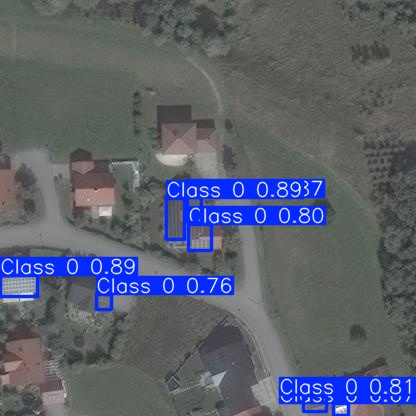

In [ ]:
from PIL import Image, ImageDraw
img = Image.open("runs/detect/predict2/" + files[0])
img

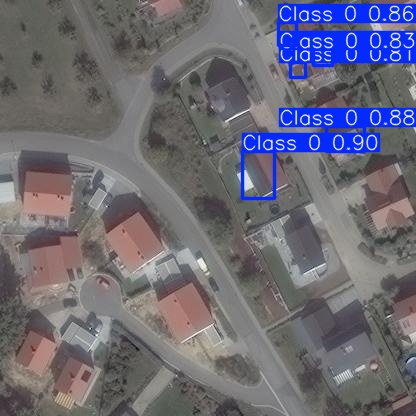

In [ ]:
img = Image.open("runs/detect/predict2/" + files[1])
img

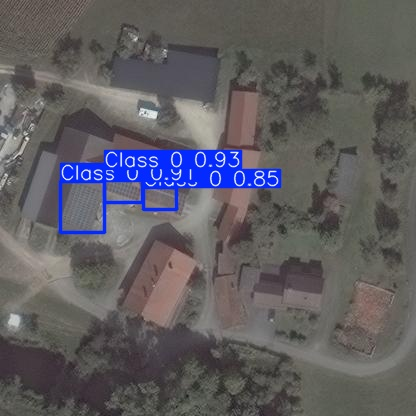

In [ ]:
img = Image.open("runs/detect/predict2/" + files[2])
img

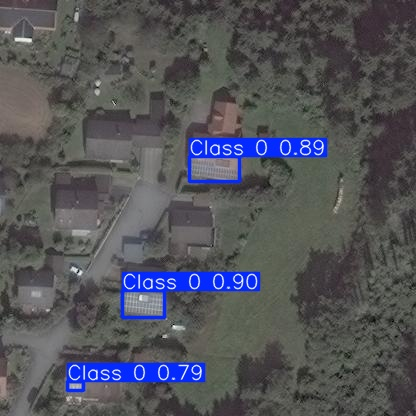

In [ ]:
img = Image.open("runs/detect/predict2/" + files[3])
img

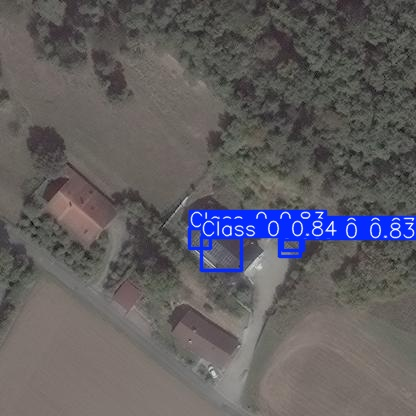

In [ ]:
img = Image.open("runs/detect/predict2/" + files[4])
img